# Projekt - odovzdanie 2

**Autori:** Patrik Villant, Ivan Vykopal
 
**Cvičenie:** Utorok o 14:00
 
**Cvičiaci:** Ing. Peter Bakonyi
 
**Dátová sada:** 55
 
**Podiel práce:** 50/50

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime
import math
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

Trieda, ktorá zlúči 2 datasety na základe stĺpcov, ktorý sa nachádza ako parameter tejto riedy.

In [2]:
class MergeTransformer(TransformerMixin):
    def __init__(self, personal, other, columns=['name', 'address']):
        self.personal = personal
        self.other = other
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = pd.merge(self.personal, self.other, on=self.columns, how = 'inner')
        return data

Trieda, ktorá slúži na rozdelenie atribútu medical-info na viaceré atribúty.

In [3]:
class SplittingMedicalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            row = data.medical_info[i]
            if str(row) == 'nan':
                j ={'mean_glucose': np.nan,
                     'std_glucose': np.nan,
                     'kurtosis_glucose': np.nan,
                     'skewness_glucose': np.nan,
                     'mean_oxygen': np.nan,
                     'std_oxygen': np.nan,
                     'kurtosis_oxygen': np.nan,
                     'skewness_oxygen': np.nan}
            else:
                j = eval(str(row))
            data.at[i,'mean_glucose'] = float(j['mean_glucose'])
            data.at[i,'std_glucose'] = float(j['std_glucose'])
            data.at[i,'kurtosis_glucose'] = float(j['kurtosis_glucose'])
            data.at[i,'skewness_glucose'] = float(j['skewness_glucose'])
            data.at[i,'mean_oxygen'] = float(j['mean_oxygen'])
            data.at[i,'std_oxygen'] = float(j['std_oxygen'])
            data.at[i,'kurtosis_oxygen'] = float(j['kurtosis_oxygen'])
            data.at[i,'skewness_oxygen'] = float(j['skewness_oxygen'])
        data = data.drop(columns=['medical_info'])
        return data

Trieda, ktorá slúži na deduplikáciu záznamov. V rámci nej sa nájdu duplicitné záznamy, a všetky duplicity sa spoja tak, že NaN hodnoty sa nahradia známymi hodnota zo záznamu, ktorý je duplicitný.

In [4]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self, columns=['name', 'address']):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        duplicates = data[data.duplicated(self.columns)]
        unique_names = duplicates.name.unique()
        for i in unique_names: 
            helper = data[data.name == i]
            helper = helper.fillna(method='ffill')
            helper = helper.drop_duplicates(self.columns, keep = 'last')
            data = data.append(helper)
    
        data.drop_duplicates(self.columns, inplace = True, keep = 'last')
        data = data.reset_index(drop = True)
        return data

Trieda, ktorá slúži na odstránenie prázdnych znakov, častokrát, ktoré sa nachadzajú na začiatku alebo konci.

In [5]:
class StripTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data[self.columns] = data[self.columns].apply(lambda x: x.str.strip())
        return data

Trieda, ktorá zjednotí záznamy, ktoré obsahujú otázniky (využíva regex, teda môže byť viac otáznikov) na NaN hodnoty.

In [6]:
class UnificationToNanTransformer(TransformerMixin):
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.replace(to_replace=r'\?+', value=np.nan, regex=True, inplace=True)
        return data

Trieda na zjednotenie dátumu na jednotný formát: RRRR-MM-DD (0000-00-00).

In [7]:
class DateUnificationTransformer(TransformerMixin):
    
    def _unifyFormats(self, data):
        data = data[:10]
        date = re.sub('[0-9]','0', data)
        if date == '0000/00/00':
            data = data.replace('/', '-')
        if date == '00/00/0000':
            data = data[6:] + '-' + data[3:5] +'-' + data[:2]
        if date == '00-00-00':
            if data[0] == 0 or data[0] == 1:
                data = '20' + data[:2] + '-' + data[3:5] + '-' + data[6:]
            else:
                data = '19' + data[:2] + '-' + data[3:5] + '-' + data[6:]
        
        return data
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['date_of_birth'] = data['date_of_birth'].apply(self._unifyFormats)
        return data

Trieda, ktorá adresu rozdelí na stĺpce street, town a psc. 

In [8]:
class AddressUnificationTransformer(TransformerMixin):
    
    def _splittAddress(self, data):
        data['street'] = 'street'
        data['town'] = 'town'
        data['psc'] = 'psc'
        for i in range(len(data.address)):
            helper = re.split('\n|, ', data.address[i])
            data.loc[i, 'street'] = str(helper[0]).strip()
            data.loc[i, 'town'] = str(helper[1])
            if len(helper) == 2:
                data.loc[i, 'town'] = str(helper[1][:-8])
                data.loc[i, 'psc'] = str(helper[1][-8:])
            if len(helper) == 3:
                data.loc[i, 'psc'] = str(helper[2])
        data = data.drop(columns=['address'])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = self._splittAddress(data)
        return data

Ako sme zistili pri prieskumnej analýze, vek obsahuje aj nereálne hodnoty, preto je potrebné tieto hodnoty nejako dopočítať a to dopočítanie vykonávame na základe dátumu narodenia (date_of_birth). Pri zisťovaní podľa, ktorého roka sa vek rátal sme prišli na rok 2019 a zvolili sme koniec roka 2019. Táto trieda, vypočíta vek pacienta na základe dátumu narodenia.

In [9]:
class AgeUnificationTransformer(TransformerMixin):
    
    def _unifyAge(self, data):
        date = datetime.date(2019, 12, 31)
        birth = datetime.date(int(data[:4]), int(data[5:7]), int(data[8:]))
        age = date - birth
        age = age.days // 365
        return age
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['age'] = data['date_of_birth'].apply(self._unifyAge)
        return data

Pre pregnant sme mali viaceré reprezentácie pre identifikáciu tehotnej osoby alebo osoby, ktorá nebolo tehotná. Toto je potrebné zjednotiť. Zároveň, aby sme odstránili aj chýbajúce hodnoty pre osoby, ktoré majú pohlavie Male sme dali automaticky, že nie sú tehotní. V rámci tohto kroku sme vykonali aj zmenu kategorickej hodnoty na číselnú reprezenáciu. Hodnota 1 určuje tehotnú osobu a hodnota 0 určuje osobu, ktorá nie je tehotná.

In [10]:
class PregnantUnificationTransformer(TransformerMixin):
          
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            if data.loc[i, 'pregnant'] in ['f','F','FALSE']:
                data.loc[i, 'pregnant'] = int(0)
            elif data.loc[i, 'pregnant'] in ['t','T','TRUE']:
                data.loc[i, 'pregnant'] = int(1)
            elif data.loc[i, 'sex'] == 'Male':
                data.loc[i, 'pregnant'] = int(0)
            else: 
                data.loc[i, 'pregnant'] = np.nan
        data.pregnant = data.pregnant.astype('int64')
        return data

Zjednotenie atribútu workclasss, keďže viaceré hodnoty sú podobné, avšak líšia sa v začiatočnom písmene napr. private a Private. Zjednocujeme to na malé začiatočné písmeno.

In [11]:
class WorkclassUnificationTransformer(TransformerMixin):
    def _unifyWorkclass(self, data):
        string = str(data).lower()
        if string == 'nan':
            return np.nan
        else:
            return string
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.workclass = data.workclass.apply(self._unifyWorkclass)
        return data

Zjednotenie atribútu realtionship, keďže viaceré hodnoty sú podobné, avšak líšia sa v oddeľovači slov ako je _ a -. Táto trieda to zjednocuje na -.

In [12]:
class RelationshipUnificationTransformer(TransformerMixin):
    def _unifyRelationship(self, data):
        string = str(data)
        if string == 'nan':
            return np.nan
        else:
            return string.replace('_', '-')
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['relationship'] = data['relationship'].apply(self._unifyRelationship)
        return data

Trieda na nahradenie chýbajúcich hodôt medianom.

In [13]:
class MedianTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.medians[column] = data[column].median()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.medians[column], inplace=True)
            
        return data

Trieda na nahradenie chýbajúcich hodôt priemerom.

In [14]:
class MeanTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}
        
    def fit(self, data, y=None):      
        for column in self.columns:
            self.means[column] = data[column].mean()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.means[column], inplace=True)
            
        return data

Trieda na nahradenie chýbajúcich hodôt najčastejšou hodnotou.

In [15]:
class MostFrequentTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.modes[column] = data[column].mode()[0]
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.modes[column], inplace=True)
            
        return data

Trieda na nahradenie chýbajúcich hodôt k najbližšími susedmi, kde k je 5.

In [16]:
class KNNTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _kNN(self, data, column):
        imp_kNN = KNNImputer(missing_values=np.nan)
        data[column] = imp_kNN.fit_transform(data[[column]])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data = self._kNN(data, column)
            
        return data

Nahradenie záporných vekov na Nan hodnotu.

In [17]:
class AgeToNanTransformer(TransformerMixin):
        
    def _ageToNan(self, data):
        if data < 0:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['age'] = data['age'].apply(self._ageToNan)   
        return data

Trieda, ktorá odstráni záznamy, ktoré majú chýbajúcu hodnotu v atribúte class.

In [18]:
class ClassRemovalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data = data[data['class'].notna()]  
        return data


Trieda na vyriešenie vychýlených hodnôt, zistíme počet vychýlených hodnôt tieto vychýlené hodnoty sa nahradia buď 5-percentilom alebo 95-percentilom a potom sa vypíšu, koľko je outlierov na kontrolu.

In [19]:
class OutliersTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _standarddeviation(self, data):
        data_mean, data_std = np.mean(data), np.std(data)

        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        outliers = [x for x in data if x < lower or x > upper] 
        print('Počet záznamov=', len(data), ', počet outlierov: %d' % len(outliers))
        print('\n')
                
    def _setOutliers(self, data, column):
        percentile_95 = data[column].quantile(0.95)
        percentile_05 = data[column].quantile(0.05)
        data.loc[data[column] < percentile_05, column] = percentile_05
        data.loc[data[column] > percentile_95, column] = percentile_95
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            print('Atribút ', column, '\n')
            print('Pred úpravou:')
            self._standarddeviation(data[column])
            self._setOutliers(data, column)
            print('Po úprave:')
            self._standarddeviation(data[column])
            print('-------------------------------------------------------------------------------------------------------------')

            
        return data

Trieda, ktorá na jednotlivé stĺpce vykoná power transformáciu na základe metódy **yoe-johnson**, je to z dôvodu, že v dátach máme aj záporné hodnoty.

In [20]:
class PowerTransformTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _powerTransform(self, data, column):
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data[column] = power.fit_transform(data[[column]])
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            self._powerTransform(data, column)
            
        return data

Zmena nezmyselných pracovných hodnín na NaN, ak je pracovná doba menšia ako 0 alebo väčšia ako 168 hodín za týždeň.

In [21]:
class HoursUnificationTransformer(TransformerMixin):
        
    def _hoursToNan(self, data):
        if data < 0 or data > 168:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['hours-per-week'] = data['hours-per-week'].apply(self._hoursToNan)   
        return data

Tým, že potrebujeme previesť všetky kategorické záznamy na číslené využijeme to, že každá kategória sa namapuje na danú číselnú hodnotu. V rámci metódy fit sa ukladá mapovanie kategorických atribútov pre jednotlivé stĺpce.

In [22]:
class LabelEncoderTransformer(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
        for column in self.columns:
            self.encoders[column] = LabelEncoder()
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.encoders[column].fit(data[column])
        return self
    
    def transform(self, data, y=None): 
        for column in self.columns:
            data[column] = self.encoders[column].transform(data[column])
        return data

Vytvorili sme triedu na výber K najlepších features pre dáta na základe cieľovej hodnoty (y).

In [23]:
class KBestFeaturesTransformer(TransformerMixin):
        
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        X_new = SelectKBest(mutual_info_regression, k=self.k).fit_transform(data, y)
        print(X_new.shape)
        return X_new  

Je potrebné zredukovať dáta na menší počet. Pre túto úlohu sme vytvorili funkciu, ktorá zredukuje počet atribútov na 2.

In [24]:
class DimensionReductionTransformer(TransformerMixin):
        
    def __init__(self, n_components=2):
        self.n_components = n_components
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        svd = TruncatedSVD(n_components=self.n_components)
        X_svd = svd.fit_transform(data)
        print('SVD: reduced shape', X_svd.shape)
        return X_svd

Načítanie dát zo súborov personal_train a other_train, kde sme rovno odstránili atribút Unnamed: 0

In [25]:
personal = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')
personal.head()

name                                            address   age  \
0  Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ... -4700   
1     Ernest Kline  391 Ball Road Suite 961\r\nFlowersborough, IN ...    52   
2  Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614    46   
3   Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311    43   
4  Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...    68   

       sex        date_of_birth  
0   Female  1972-03-14 00 00 00  
1     Male  1967-02-10 00:00:00  
2   Female           1972/12/15  
3     Male           1976-03-16  
4     Male           1951-05-04

In [26]:
other = pd.read_csv('other_train.csv', index_col='Unnamed: 0')
other.head()

name                                            address    race  \
0     Nelson Dupas                         USS Wagner\r\nFPO AP 75518   White   
1  Jeremy Helfrich          0611 Jones Cliffs\r\nPort Kevin, AR 87203   White   
2     Luis Burdick  116 Wallace Meadow Suite 259\r\nPort Jenniferb...   White   
3    Marion Bursey   85508 Martin Villages\r\nJonathanshire, AL 29047   White   
4   Allen Brickley  58775 Thomas Mills Apt. 873\r\nLake Richardhav...   White   

        marital-status        occupation pregnant  education-num relationship  \
0   Married-civ-spouse   Exec-managerial        f           10.0      Husband   
1   Married-civ-spouse    Prof-specialty        f           15.0      Husband   
2   Married-civ-spouse   Exec-managerial        f            9.0      Husband   
3   Married-civ-spouse             Sales        f           10.0      Husband   
4   Married-civ-spouse      Craft-repair        f           13.0      Husband   

   capital-gain      education    fnlwgt  class  income  \
0           0.0   Some-college   32916.0    0.0   <=50K   
1       15024.0    Prof-school  323798.0    0.0    >50K   
2           0.0        HS-grad  116927.0    1.0    >50K   
3           0.0   Some-college  206351.0    0.0   <=50K   
4           0.0      Bachelors   37939.0    0.0   <=50K   

                                        medical_info  native-country  \
0  {'mean_glucose':'129.6171875','std_glucose':'4...   United-States   
1  {'mean_glucose':'100.546875','std_glucose':'39...   United-States   
2  {'mean_glucose':'26.09375','std_glucose':'nan'...   United-States   
3  {'mean_glucose':'113.0625','std_glucose':'42.8...   United-States   
4  {'mean_glucose':'131.1328125','std_glucose':'4...   United-States   

   hours-per-week  capital-loss          workclass  
0            45.0           0.0            Private  
1            55.0           0.0            Private  
2            42.0           0.0       Self-emp-inc  
3            40.0           0.0            Private  
4            35.0           0.0   Self-emp-not-inc

Vytvorili sme pipeline len pre spojenie datasetov do jednej tabuľky **data** na základe mena a adresy. Následne vykonávame kontrolu pomocou výpisu.

In [27]:
# pipeline pre spojenie dát
merge = Pipeline([('merge', MergeTransformer(personal, other, ['name', 'address']))])

data = pd.DataFrame()
data = merge.transform(data)
data.head()

name                                            address   age  \
0  Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ... -4700   
1     Ernest Kline  391 Ball Road Suite 961\r\nFlowersborough, IN ...    52   
2  Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614    46   
3   Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311    43   
4  Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...    68   

       sex        date_of_birth    race       marital-status       occupation  \
0   Female  1972-03-14 00 00 00   White             Divorced    Other-service   
1     Male  1967-02-10 00:00:00   White   Married-civ-spouse   Prof-specialty   
2   Female           1972/12/15   White   Married-civ-spouse            Sales   
3     Male           1976-03-16   White   Married-civ-spouse                ?   
4     Male           1951-05-04   White             Divorced   Prof-specialty   

  pregnant  education-num  ... capital-gain     education    fnlwgt  class  \
0        f            7.0  ...          0.0          11th  358056.0    0.0   
1        f           15.0  ...          0.0   Prof-school  202027.0    0.0   
2        f            9.0  ...          0.0       HS-grad  103459.0    0.0   
3        f            4.0  ...          0.0       7th-8th  190205.0    0.0   
4        f           13.0  ...          0.0     Bachelors  210452.0    1.0   

   income                                       medical_info  native-country  \
0   <=50K  {'mean_glucose':'125.8203125','std_glucose':'4...   United-States   
1    >50K  {'mean_glucose':'113.203125','std_glucose':'51...   United-States   
2    >50K  {'mean_glucose':'100.734375','std_glucose':'48...   United-States   
3   <=50K  {'mean_glucose':'122.3984375','std_glucose':'4...   United-States   
4   <=50K  {'mean_glucose':'47.890625','std_glucose':'32....   United-States   

  hours-per-week  capital-loss  workclass  
0           40.0           0.0    private  
1           45.0           0.0    Private  
2           40.0           0.0    Private  
3           25.0           0.0          ?  
4           45.0           0.0    Private  

[5 rows x 21 columns]

Vypísanie základných informácii o dátach, ako sú jednotlivé atribúty a ich typy.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            3983 non-null   object 
 1   address         3983 non-null   object 
 2   age             3983 non-null   int64  
 3   sex             3983 non-null   object 
 4   date_of_birth   3983 non-null   object 
 5   race            3967 non-null   object 
 6   marital-status  3710 non-null   object 
 7   occupation      3965 non-null   object 
 8   pregnant        3967 non-null   object 
 9   education-num   3965 non-null   float64
 10  relationship    3964 non-null   object 
 11  capital-gain    3963 non-null   float64
 12  education       3967 non-null   object 
 13  fnlwgt          3969 non-null   float64
 14  class           3968 non-null   float64
 15  income          3966 non-null   object 
 16  medical_info    3968 non-null   object 
 17  native-country  3967 non-null   o

Skopírovanie datasetu, kópiu neskôr využijeme pri porovnávaní výsledkov. Zároveň tento dataset upravíme tým, že rozdelíme atribút medical-info na viaceré atribúty, tak aby sme vedeli znázorniť rozdieli pred úpravou a po úprave.

In [29]:
data_before = data.copy()

In [30]:
split = SplittingMedicalTransformer()
data_before = split.transform(data_before)

Pri prvej fáze sme zistili, že máme v dátach duplicity. Je potrebné zistiť, či sú tieto duplicity rovnaké aj podľa mena, ale aj podľa adresy.

In [31]:
# zistenie či sú duplicity rovnaké aj podľa mena aj podľa adresy
if list(data.name.duplicated()) == list(data.address.duplicated()):
    print('Duplikáty rovnaké na základe mena a adresy.')
else:
    print('Duplikáty nie sú rovnaké na základe mena a adresy.')

Duplikáty rovnaké na základe mena a adresy.


Pri atribúte **date_of_birth** je potrebné zjednotitť formáty dátumov, preto sme najskôr zistili aké formáty sa využívajú.

In [32]:
formats = data['date_of_birth'].str.replace('[0-9]','0').value_counts()
formats

0000-00-00             2680
0000-00-00 00:00:00     280
0000/00/00              265
00/00/0000              260
00-00-00                254
0000-00-00 00 00 00     244
Name: date_of_birth, dtype: int64

Zistenie unikátnych záznamov pre atribút **workclass**.

In [33]:
data['workclass'].unique()

array(['private', ' Private', ' ?', ' Local-gov', ' Self-emp-not-inc',
       'state-gov', ' State-gov', 'self-emp-not-inc', 'self-emp-inc',
       ' Self-emp-inc', nan, '?', 'federal-gov', ' Federal-gov',
       'local-gov', ' Without-pay'], dtype=object)

Zistenie unikátnych záznamov pre atribút **relationship**.

In [34]:
data.relationship.unique()

array([' Unmarried', ' Husband', ' Wife', ' Own-child', ' Not-in-family',
       ' Other-relative', ' Own_child', ' Not_in_family', nan,
       ' Other_relative'], dtype=object)

Vytvorili sme pipeline, ktorá deduplikuje dáta a zjednotí jednotlivé atribúty na základe určitých pravidiel.

### Popis krokov pipeline:

- Najskôr sme rozdelili atribút **medical_info** na samostatné stĺpce, tak ako to bolo pri prieskumnej analýze.

- Následne riešime duplikátne záznamy tak, že sa spájajú do jedného záznamu.

- Po deduplikácii sme odstránicli z atribútov typu object prázdne znaky a medzery navyšše.

- Zjednotili sme chýbajúce hodnoty na NaN, z dôvodu, že chýbajúce hodnoty boli interpretované rôzne, v tomto prípade riešíme  rôzny počet "?".

- Zistili sme, že v atribúte **date_of_birth** sa nachádza 6 druhov, ktoré sme zjednotili na jeden, pričom sme si vybrali formát: RRRR-MM-DD (0000-00-00)

- Atribút **address** sme rozdelili na viacero stĺpcov, konkrétne na street, town a psc.

- Ako sme zistili pri prieskumnej analýze, vek obsahuje aj nereálne hodnoty, preto je potrebné tieto hodnoty nejako dopočítať a to dopočítanie vykonávame na základe dátumu narodenia (date_of_birth). Pri zisťovaní podľa, ktorého roka sa vek rátal sme prišli na rok 2019 a zvolili sme koniec roka 2019.

- Dopočítali sme vek pre pacientov na základe ich dátumu narodenia.

- Zjednotili sme rôzne druhy vyjadrenia tehotenstva a zmenili sme to na číselnú hodnotu 0 a 1.

- Zjednotili sme **workclass** tak, že sme každú hodnotu previedli na lowercase a tak sme odstránili duplicitné kategórie.

- Zjednotili sme atribút **relationship** s tým, že sme prevideli rozdelenie slov z _ na -.

- Zároveň každý záporný vek už po predchádzajúcich úpravách, ktorý nájdeme konvertujeme na NaN hodnotu. 

In [35]:
pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer())])


pip.fit(data)
data = pip.transform(data)

In [36]:
data.name.duplicated().sum()

0

Po deduplikácii sme zistili, že už v dátach nemáme žiadne duplicitné záznamy.

In [37]:
data.head(20)

name   age     sex date_of_birth                race  \
0        Roscoe Bohannon  47.0  Female    1972-03-14               White   
1           Ernest Kline  52.0    Male    1967-02-10               White   
2        Harold Hendriks  47.0  Female    1972-12-15               White   
3         Randy Baptiste  43.0    Male    1976-03-16               White   
4        Anthony Colucci  68.0    Male    1951-05-04               White   
5           Ronald Lange  59.0    Male    1960-11-24               White   
6          Boyd Eiselein  48.0  Female    1972-01-05               White   
7          Raymond Smith  52.0    Male    1967-10-05               White   
8          Harold Miller  44.0    Male    1975-07-04  Asian-Pac-Islander   
9   Charles Czachorowski  70.0  Female    1949-03-24               White   
10       Robert Grantham  59.0    Male    1960-08-22               White   
11              Joel Lam  52.0    Male    1967-05-22               White   
12            Irving Gil  55.0  Female    1964-10-30               White   
13        Terry Reynolds  54.0    Male    1965-12-11               White   
14      Kurt Littlefield  39.0    Male    1980-06-26               White   
15          Andy Grayson  24.0    Male    1995-09-13               White   
16       Chauncey Suarez  63.0  Female    1956-01-23  Amer-Indian-Eskimo   
17        Wallace Street  58.0    Male    1961-07-30               White   
18       Daniel Crossman  59.0    Male    1960-02-22  Asian-Pac-Islander   
19            Steve Ripp  49.0    Male    1970-03-31               White   

        marital-status         occupation  pregnant  education-num  \
0             Divorced      Other-service         0            7.0   
1   Married-civ-spouse     Prof-specialty         0           15.0   
2   Married-civ-spouse              Sales         0            9.0   
3   Married-civ-spouse                NaN         0            4.0   
4             Divorced     Prof-specialty         0           13.0   
5   Married-civ-spouse       Craft-repair         0            9.0   
6        Never-married      Other-service         0           13.0   
7   Married-civ-spouse       Craft-repair         0            9.0   
8   Married-civ-spouse       Adm-clerical         0            9.0   
9              Widowed              Sales         0            5.0   
10  Married-civ-spouse     Prof-specialty         0           11.0   
11  Married-civ-spouse     Prof-specialty         0           13.0   
12       Never-married  Handlers-cleaners         0            9.0   
13            Divorced      Other-service         0           10.0   
14  Married-civ-spouse                NaN         0           14.0   
15  Married-civ-spouse    Exec-managerial         0           13.0   
16            Divorced       Tech-support         0           10.0   
17  Married-civ-spouse              Sales         0           10.0   
18  Married-civ-spouse       Tech-support         0           12.0   
19  Married-civ-spouse  Machine-op-inspct         0            9.0   

     relationship  ...  std_glucose kurtosis_glucose  skewness_glucose  \
0       Unmarried  ...    47.632944        -0.067937          0.416589   
1         Husband  ...    51.857581         0.307464          0.137797   
2            Wife  ...    48.437538         0.516160          0.257656   
3         Husband  ...    43.873636         0.331999          0.580821   
4       Unmarried  ...    32.219519         3.475947         16.653193   
5         Husband  ...    37.863794         1.255240          3.467668   
6       Own-child  ...    46.584758         0.196338          0.345917   
7         Husband  ...    44.427494         0.390189          0.264724   
8         Husband  ...    55.554168        -0.238754         -0.467586   
9       Unmarried  ...    50.645640         1.990830          3.713695   
10        Husband  ...    52.984573         0.179128         -0.311661   
11        Husband  ...    37.290967         3.520712         13.

In [38]:
formats = data['date_of_birth'].str.replace('[0-9]','0').value_counts()
formats

0000-00-00    3933
Name: date_of_birth, dtype: int64

Po aplikovaní zjednotenia sme skontrolovali, či atribút date_of_birth obsahuje len jeden formát, čo sa nám potvrdilo.

Výpis prvých pár adries na kontrolu správnosti rozdelenia atribútu **address**.

In [39]:
data.age.describe()

count    3932.000000
mean       52.099440
std        11.841595
min         4.000000
25%        45.000000
50%        52.000000
75%        60.000000
max       115.000000
Name: age, dtype: float64

In [40]:
data.pregnant.isnull().sum()

0

Po vyriešení atribútu pregnant sme skontrolovali, či existujú nejaké chýbajúce hodnoty pre tento atribút, čo sa nám nepotvrdilo a teda, už pre atribút pregnant nemáme, žiadne chýbajúce hodnoty.

Výpis unikátnych hodnôt atribútu **workclass** pre kontrolu správnosti úpravy.

In [41]:
data.workclass.unique()

array(['private', nan, 'local-gov', 'self-emp-not-inc', 'state-gov',
       'self-emp-inc', 'federal-gov', 'without-pay'], dtype=object)

Výpis unikátnych hodnôt atribútu **relationship** pre kontrolu správnosti úpravy.

In [42]:
data.relationship.unique()

array(['Unmarried', 'Husband', 'Wife', 'Own-child', 'Not-in-family',
       'Other-relative', nan], dtype=object)

# Riešenie chýbajúcich hodnôt

Po všetkých vyššie vykonaných upravách je potrebné vypísať jednotlivé atribúty, aby sme videli koľko pre každý atribút je chýbajúcich hodnôt.

In [43]:
data.isnull().sum()

name                  0
age                   1
sex                   0
date_of_birth         0
race                  1
marital-status      395
occupation          225
pregnant              0
education-num         0
relationship          1
capital-gain          1
education             0
fnlwgt                0
class                 1
income                0
native-country       61
hours-per-week        2
capital-loss          1
workclass           226
mean_glucose          1
std_glucose         394
kurtosis_glucose      1
skewness_glucose      1
mean_oxygen           1
std_oxygen            1
kurtosis_oxygen       1
skewness_oxygen       1
street                0
town                  0
psc                   0
dtype: int64

Na základe tabuľky vyššie vidíme, že najviac chýbajúcich hodnôt je prei marital-status, occupation, native-country a std_glucose. Ostatné atribúty majú málo chýbajúcich hodnôt.

## Nahradenie chýbajúcich hodnôt v jednotlivých atribútoch

Vytvorili sme ďalšiu pipeline, ktorá nahrádza chýbajúce hodnoty v jednotlivých atribútoch.

Najskôr sme vytvorili rôzne listy s názvami atribútov, a na každú túto množinu atribút využívame roôzne nahrádzanie hodnôt.

### Popis krokov pipeline:

- Najskôr sme nahradili v kategorických atribútoch a v atribútoch capital-gain a capital-loss chýbajúce hodnoty najčastejšou hodnotou daného atribútu.

- Následne sme odstránili tie záznamy, ktoré majú chýbajúce hodnoty v atribúte class, aby nám neskôr neskreslovali výsledky.

- Pre atribút **hours-per-week** sme chýbajúce hodnoty nahradili priemerom.

- Pre atribúty súvisiace s glukózou sme využili nahradenie chýbajúcich hodnôt pomocou k najbližších susedov.

- Pre atribúty súvisiace s kyslíkom a atribút **age** sme využili nahradenie chýbajúcich hodnôt pomocou mediánu.

In [44]:
most_frequent_missing = ['race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

missing = Pipeline([('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
                   ('class_remove', ClassRemovalTransformer()),
                   ('hours-per-week', MeanTransformer(['hours-per-week'])),
                   ('glucose', KNNTransformer(glucose)),
                   ('oxygen_age', MedianTransformer(oxygen_age))])

missing.fit(data)
data = missing.transform(data)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-16-d0499de3fbb9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = imp_kNN.fit_transform(data[[column]])
<ipython-input-16-d0499de3fbb9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Následne sme dali vypísať počty pre jednotlivé kategorické atribúty.

In [45]:
data['race'].value_counts()

White                 3362
Black                  366
Asian-Pac-Islander     132
Amer-Indian-Eskimo      38
Other                   34
Name: race, dtype: int64

In [46]:
data['marital-status'].value_counts()

Married-civ-spouse       2003
Never-married            1187
Divorced                  461
Separated                 125
Widowed                   106
Married-spouse-absent      46
Married-AF-spouse           4
Name: marital-status, dtype: int64

In [47]:
data['occupation'].value_counts()

Prof-specialty       749
Craft-repair         516
Exec-managerial      504
Adm-clerical         443
Sales                416
Other-service        385
Machine-op-inspct    243
Transport-moving     192
Handlers-cleaners    154
Farming-fishing      123
Tech-support         110
Protective-serv       77
Priv-house-serv       18
Armed-Forces           2
Name: occupation, dtype: int64

In [48]:
data['relationship'].value_counts()

Husband           1580
Not-in-family     1049
Own-child          590
Unmarried          419
Wife               187
Other-relative     107
Name: relationship, dtype: int64

In [49]:
data['native-country'].value_counts()

United-States         3588
Mexico                  78
Philippines             30
Germany                 18
Canada                  16
England                 16
India                   13
Italy                   11
Cuba                    10
Puerto-Rico             10
Taiwan                  10
South                    9
Vietnam                  8
Dominican-Republic       8
Guatemala                8
Jamaica                  8
El-Salvador              8
Japan                    7
Iran                     7
China                    7
Columbia                 7
Portugal                 5
Thailand                 5
Trinadad&Tobago          5
Haiti                    5
Poland                   5
Nicaragua                4
Peru                     4
Ireland                  3
Cambodia                 3
France                   3
Hong                     3
Yugoslavia               2
Greece                   2
Ecuador                  2
Honduras                 2
Scotland                 1
L

In [50]:
data['workclass'].value_counts()

private             2974
self-emp-not-inc     285
local-gov            249
state-gov            159
self-emp-inc         138
federal-gov          126
without-pay            1
Name: workclass, dtype: int64

Zobrazili sme aj grafy pre číselné atribúty, pre znázornenie ako vyzerajú po úprave.

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='capital-gain', ylabel='Density'>

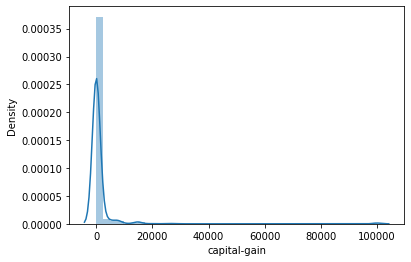

In [51]:
sns.distplot(data['capital-gain'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours-per-week', ylabel='Density'>

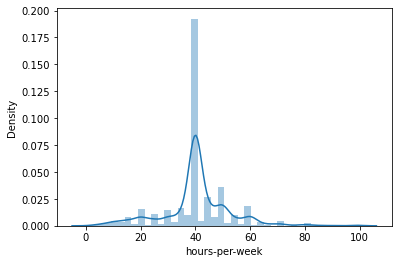

In [52]:
sns.distplot(data['hours-per-week'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours-per-week', ylabel='Density'>

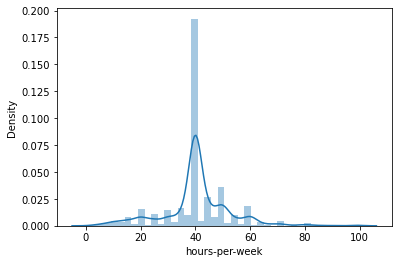

In [53]:
sns.distplot(data['hours-per-week'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='capital-loss', ylabel='Density'>

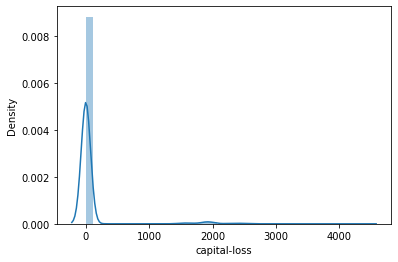

In [54]:
sns.distplot(data['capital-loss'], bins=40)

#### Grafy pre atribúty súviasiace s glukózou

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_glucose', ylabel='Density'>

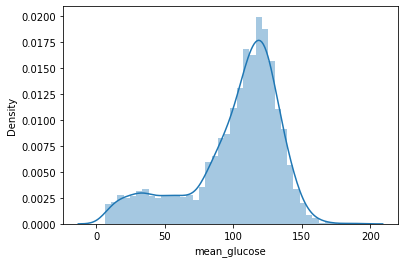

In [55]:
sns.distplot(data['mean_glucose'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='std_glucose', ylabel='Density'>

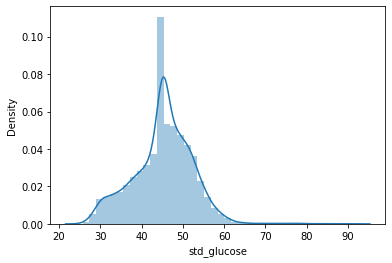

In [56]:
sns.distplot(data['std_glucose'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='kurtosis_glucose', ylabel='Density'>

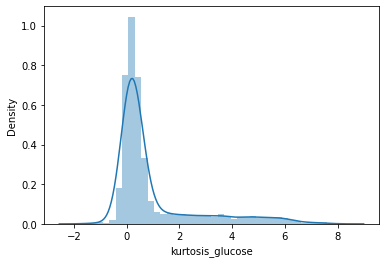

In [57]:
sns.distplot(data['kurtosis_glucose'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='skewness_glucose', ylabel='Density'>

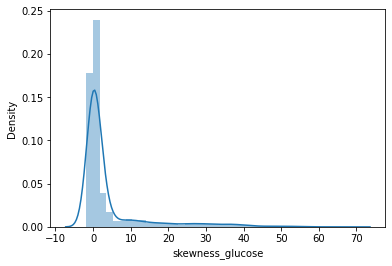

In [58]:
sns.distplot(data['skewness_glucose'], bins=40)

#### Grafy pre atribúty súviasiace s kyslíkom

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_oxygen', ylabel='Density'>

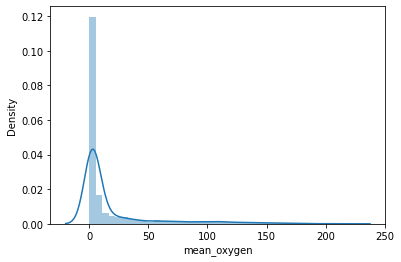

In [59]:
sns.distplot(data['mean_oxygen'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='std_oxygen', ylabel='Density'>

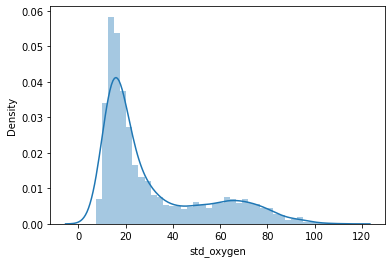

In [60]:
sns.distplot(data['std_oxygen'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='kurtosis_oxygen', ylabel='Density'>

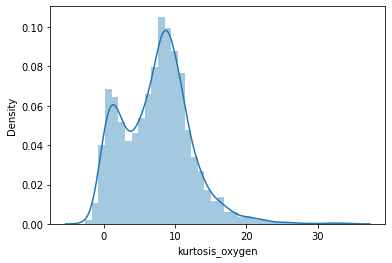

In [61]:
sns.distplot(data['kurtosis_oxygen'], bins=40)

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='skewness_oxygen', ylabel='Density'>

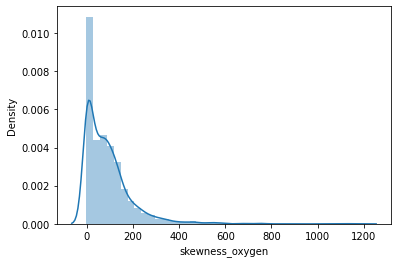

In [62]:
sns.distplot(data['skewness_oxygen'], bins=40)

Následne sme mali všetky chýbajúce hodnoty nahradené pre každý jeden atribút.

In [63]:
data.isnull().sum()

name                0
age                 0
sex                 0
date_of_birth       0
race                0
marital-status      0
occupation          0
pregnant            0
education-num       0
relationship        0
capital-gain        0
education           0
fnlwgt              0
class               0
income              0
native-country      0
hours-per-week      0
capital-loss        0
workclass           0
mean_glucose        0
std_glucose         0
kurtosis_glucose    0
skewness_glucose    0
mean_oxygen         0
std_oxygen          0
kurtosis_oxygen     0
skewness_oxygen     0
street              0
town                0
psc                 0
dtype: int64

Výpis prvých 5 riadkov výslednej tabuľky.

In [64]:
data.head()

name   age     sex date_of_birth   race      marital-status  \
0  Roscoe Bohannon  47.0  Female    1972-03-14  White            Divorced   
1     Ernest Kline  52.0    Male    1967-02-10  White  Married-civ-spouse   
2  Harold Hendriks  47.0  Female    1972-12-15  White  Married-civ-spouse   
3   Randy Baptiste  43.0    Male    1976-03-16  White  Married-civ-spouse   
4  Anthony Colucci  68.0    Male    1951-05-04  White            Divorced   

       occupation  pregnant  education-num relationship  ...  std_glucose  \
0   Other-service         0            7.0    Unmarried  ...    47.632944   
1  Prof-specialty         0           15.0      Husband  ...    51.857581   
2           Sales         0            9.0         Wife  ...    48.437538   
3  Prof-specialty         0            4.0      Husband  ...    43.873636   
4  Prof-specialty         0           13.0    Unmarried  ...    32.219519   

  kurtosis_glucose  skewness_glucose  mean_oxygen std_oxygen kurtosis_oxygen  \
0        -0.067937          0.416589     6.831940  31.570715        5.127844   
1         0.307464          0.137797     2.074415  18.641943        9.805805   
2         0.516160          0.257656     2.534281  14.571746        8.843765   
3         0.331999          0.580821     1.232441  14.850182       13.681802   
4         3.475947         16.653193     8.848662  37.140603        4.668328   

   skewness_oxygen                       street            town       psc  
0        26.878619   7183 Osborne Ways Apt. 651     East Andrew  OH 53211  
1       100.742006      391 Ball Road Suite 961  Flowersborough  IN 57550  
2       106.248030          8702 Vincent Square   New Jerryfurt  CO 30614  
3       200.063197        2751 Harris Crossroad     West Ashley  CA 30311  
4        22.050901  904 Robert Cliffs Suite 186       West Kyle  CO 77139  

[5 rows x 30 columns]

Vykreslili sme grafy pre jednotlivé atribúty na porovnanie pred a po doplnení chybajúcich hodnôt.

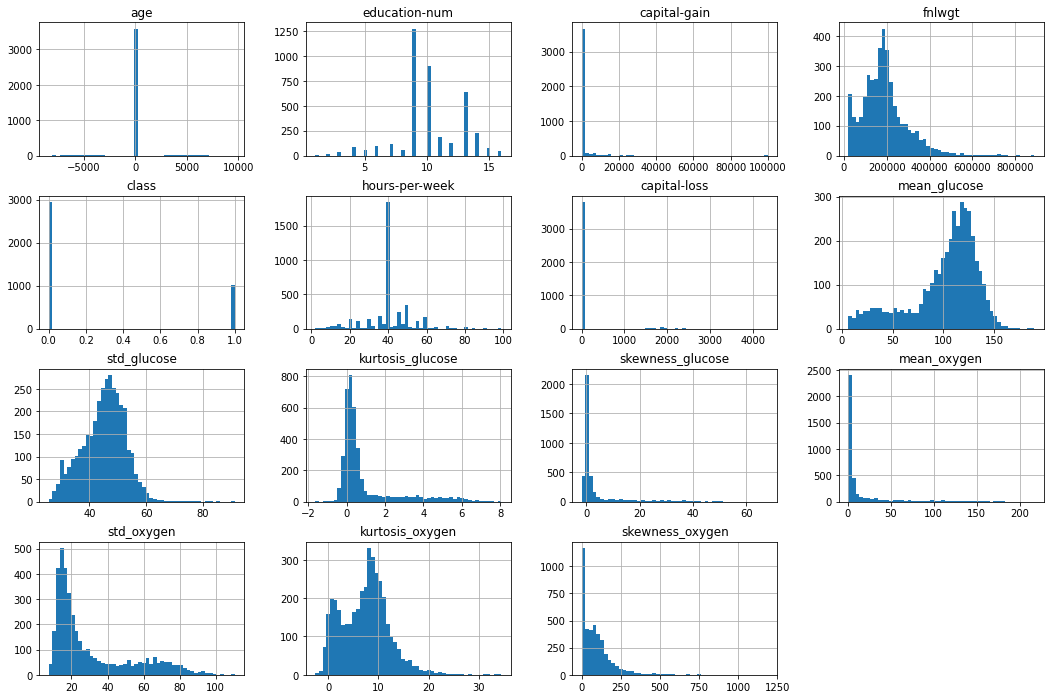

In [65]:
_ = data_before.hist(figsize=(18, 12), bins=50)

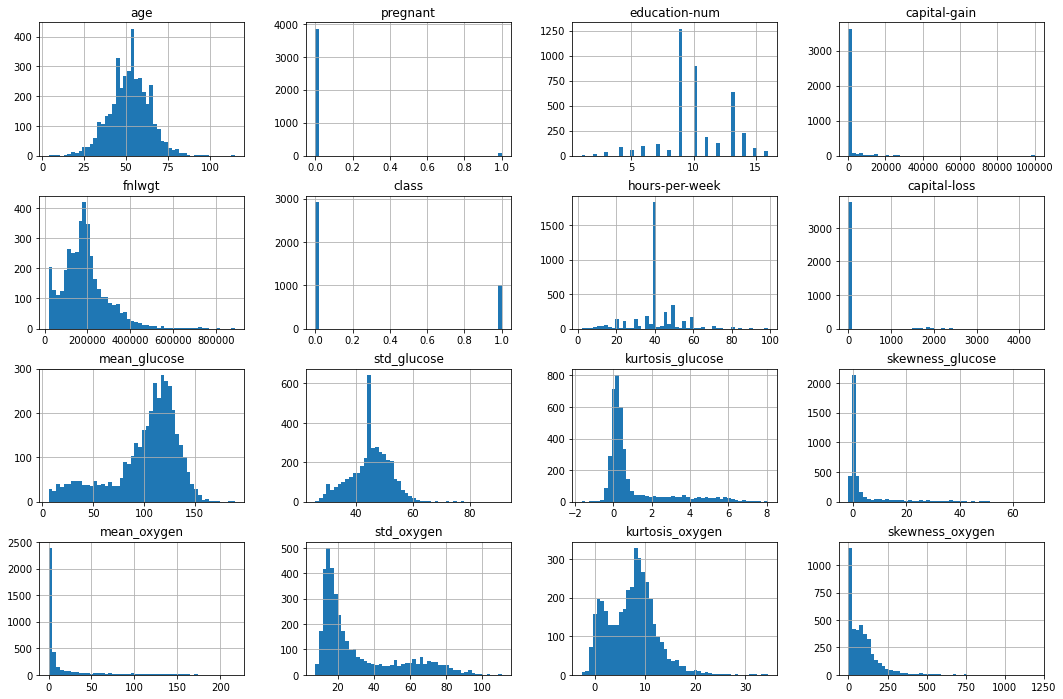

In [66]:
_ = data.hist(figsize=(18, 12), bins=50)

# Riešenie vychýlených hodnôt

V tejto časti sme vytvorili ďalšiu pipeline, pre riešenie vychýlených hodnôt a transformáciu jednotlivých atribútov.


### Popis krokov pipeline:

- Najkôr sme vykonali transformáciu nad číselnými atribútmi.

- Následne sme identifikovali počet outlierov pomocou štandardnej deviácie a vychýlené hodnoty sme nahradili buď 5-percentilom alebo 95-percentilom.


In [67]:
columns = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip_outliers = Pipeline([('power_transform',PowerTransformTransformer(columns)),
                        ('outliers', OutliersTransformer(columns))])

pip_outliers.fit(data)
data = pip_outliers.transform(data)

Atribútfnlwgt

Počet záznamov= 3932
Počet outlierov: 22


Počet záznamov= 3932
Počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribútmean_glucose

Počet záznamov= 3932
Počet outlierov: 9


Počet záznamov= 3932
Počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribútstd_glucose

Počet záznamov= 3932
Počet outlierov: 18


Počet záznamov= 3932
Počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribútkurtosis_glucose

Počet záznamov= 3932
Počet outlierov: 18


Počet záznamov= 3932
Počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribútskewness_glucose

Počet záznamov= 3932
Počet outlierov: 16


Počet záznamov= 3932
Počet outlierov: 0


------------------------------

Po vykonaní úpravy vychýlených hodnôt zobrazujeme boxploty pre jednotlivé atribúty.

### Atribút fnlwgt

d:\users\ivan\fiit\5.semester\iau\python\xvykopal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fnlwgt'>

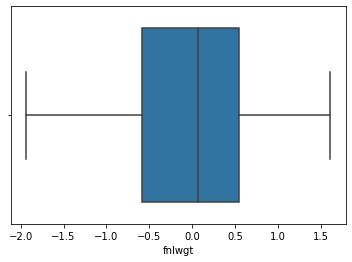

In [68]:
sns.boxplot(data['fnlwgt'])

### Atribúty spojené s glukózou

<AxesSubplot:>

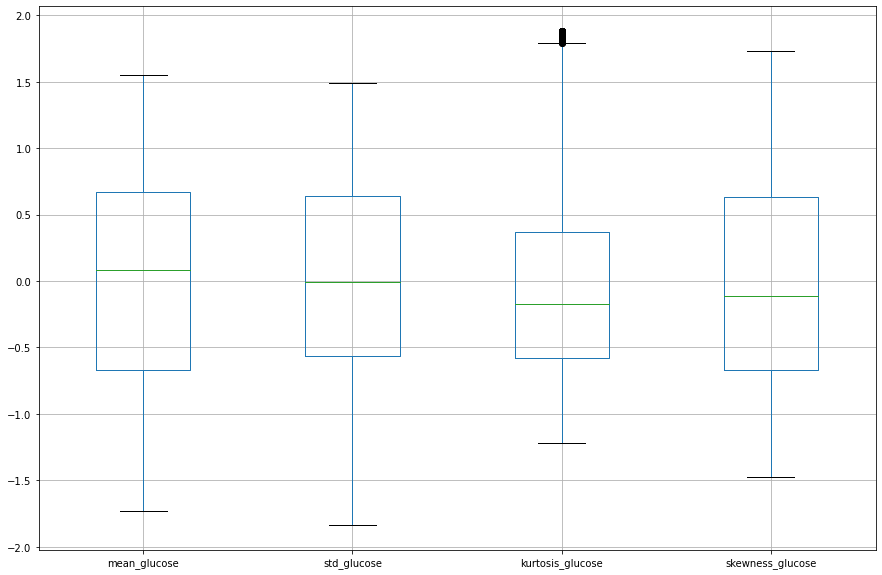

In [70]:
fig, ax = plt.subplots(figsize=(15,10))
columns = pd.DataFrame(data=data, columns=['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose'])
columns.boxplot()

### Atribúty spojené s kyslíkom

<AxesSubplot:>

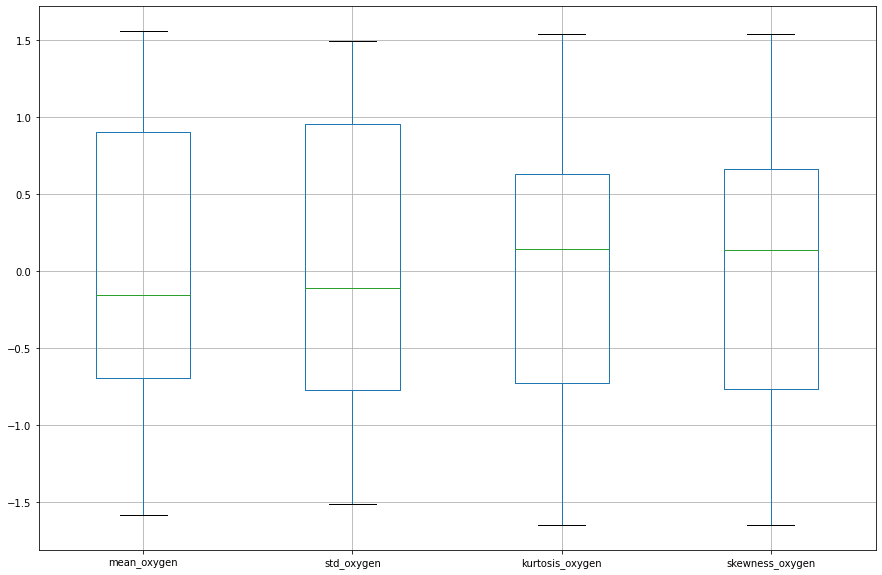

In [71]:
fig, ax = plt.subplots(figsize=(15,10))
columns = pd.DataFrame(data=data, columns=['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
columns.boxplot()

## Opätovná prieskumná analýza

Vykreslili sme histogramy pre jednotlivé atribúty na porovnanie pred úpravou dát a po doplnení chybajúcich hodnôt, normalizácii dát a vyriešenia vychýlených hodnôt. Taktiež sme pre porovnanie vypísali atribúty predošlej dátovej sady a finálnej a ich deskriptívne štatistiky.

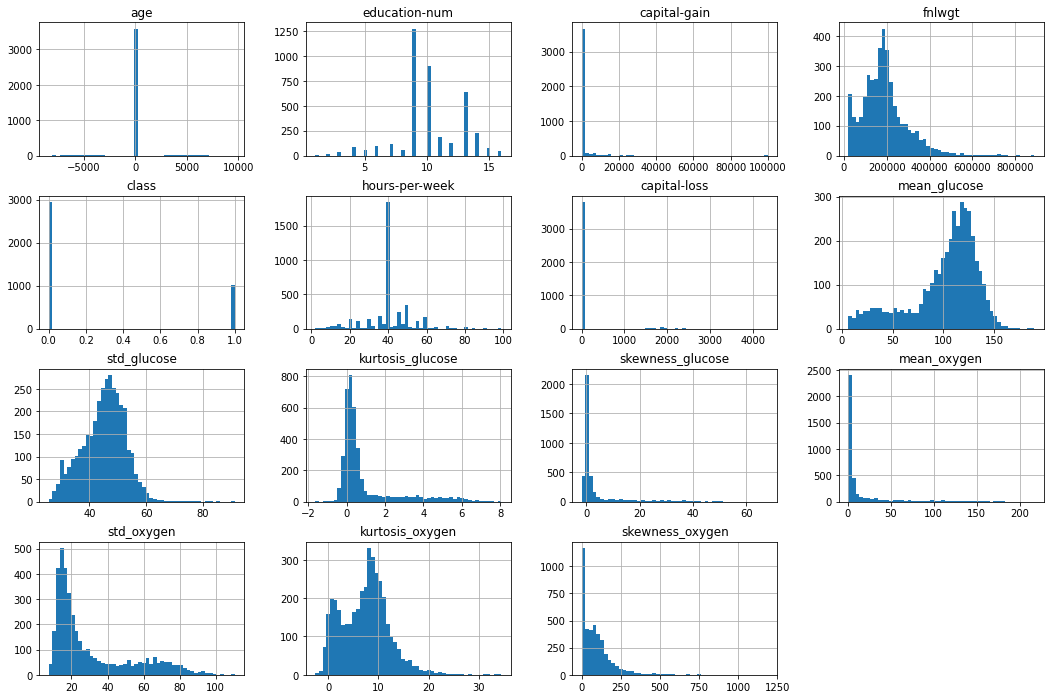

In [72]:
_ = data_before.hist(figsize=(18, 12), bins=50)

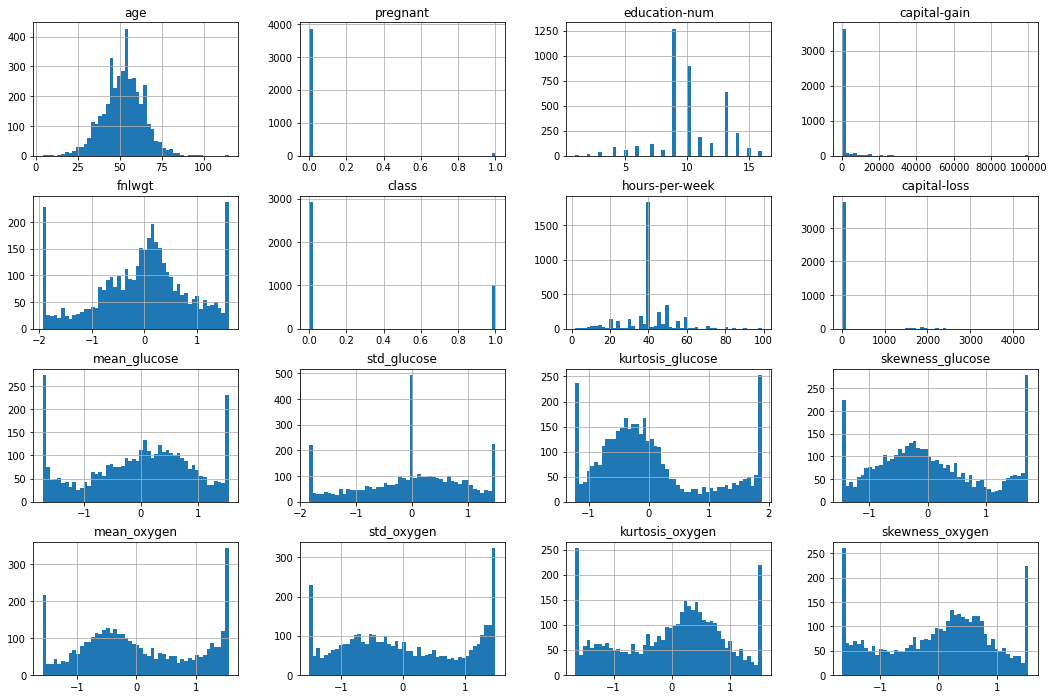

In [73]:
_ = data.hist(figsize=(18, 12), bins=50)

Po vykreslení histrogramov jednotlivých atribútov vidíme rozdiely medzi dátami pred úpravou a po úprave. Na základe týchto grafov sme zistili, že a jednotlivé rozdelenia zmenili viac k normálnym rozdelenia, avšak pri nahrádzaní outlierov nám pri jednotlivých atribútoch narástli hodnoty na krajoch distribúcií.

In [74]:
data_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   age               3983 non-null   int64  
 3   sex               3983 non-null   object 
 4   date_of_birth     3983 non-null   object 
 5   race              3967 non-null   object 
 6   marital-status    3710 non-null   object 
 7   occupation        3965 non-null   object 
 8   pregnant          3967 non-null   object 
 9   education-num     3965 non-null   float64
 10  relationship      3964 non-null   object 
 11  capital-gain      3963 non-null   float64
 12  education         3967 non-null   object 
 13  fnlwgt            3969 non-null   float64
 14  class             3968 non-null   float64
 15  income            3966 non-null   object 
 16  native-country    3967 non-null   object 


vypisovaný dataset je už po rozdelení atribútu medical-info a teda pôvodne by mal manej stĺpcov ako je ich vypísaných.

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3932 entries, 0 to 3932
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3932 non-null   object 
 1   age               3932 non-null   float64
 2   sex               3932 non-null   object 
 3   date_of_birth     3932 non-null   object 
 4   race              3932 non-null   object 
 5   marital-status    3932 non-null   object 
 6   occupation        3932 non-null   object 
 7   pregnant          3932 non-null   int64  
 8   education-num     3932 non-null   float64
 9   relationship      3932 non-null   object 
 10  capital-gain      3932 non-null   float64
 11  education         3932 non-null   object 
 12  fnlwgt            3932 non-null   float64
 13  class             3932 non-null   float64
 14  income            3932 non-null   object 
 15  native-country    3932 non-null   object 
 16  hours-per-week    3932 non-null   float64


Aj na základe týchto ifnormácií vidíme, že počet chýbajúcich hodnôt klesol na 0 oproti pôvodnému datasetu. Zároveň v upravených dátach máme pretrasnofrmované tehotenstvo na číselný atribút a nie kategorický.

In [76]:
data_before.describe()

age  education-num  capital-gain         fnlwgt        class  \
count  3983.000000    3965.000000   3963.000000    3969.000000  3968.000000   
mean     80.268642      10.115763   1069.521827  189374.662383     0.256552   
std    1726.327770       2.568333   7353.525505  105318.658007     0.436785   
min   -8400.000000       1.000000      0.000000   19410.000000     0.000000   
25%      43.000000       9.000000      0.000000  120067.000000     0.000000   
50%      52.000000      10.000000      0.000000  179973.000000     0.000000   
75%      60.000000      12.000000      0.000000  232855.000000     1.000000   
max    9700.000000      16.000000  99999.000000  889965.000000     1.000000   

       hours-per-week  capital-loss  mean_glucose  std_glucose  \
count     3965.000000   3960.000000   3968.000000  3569.000000   
mean        40.406305     76.721212    101.216507    45.149233   
std         12.375377    387.449247     33.590085     7.595777   
min          2.000000      0.000000      6.187500    25.695250   
25%         40.000000      0.000000     87.544922    40.165726   
50%         40.000000      0.000000    110.644531    45.835260   
75%         45.000000      0.000000    124.160156    50.264680   
max         99.000000   4356.000000    189.734375    91.206475   

       kurtosis_glucose  skewness_glucose  mean_oxygen   std_oxygen  \
count       3968.000000       3968.000000  3968.000000  3968.000000   
mean           0.954596          4.241261    18.467885    31.172996   
std            1.613398          9.696736    34.747837    22.294108   
min           -1.641515         -1.755332     0.213211     7.370432   
25%            0.072000         -0.120593     2.063127    15.029585   
50%            0.311577          0.379008     3.229933    20.551260   
75%            0.788435          2.107509    12.652383    43.255617   
max            8.069522         68.101622   217.371238   110.642211   

       kurtosis_oxygen  skewness_oxygen  
count      3968.000000      3968.000000  
mean          7.410578        91.257886  
std           4.809258       108.411705  
min          -2.597872        -1.976976  
25%           3.631263        12.830509  
50%           7.783017        68.505049  
75%          10.269058       127.017151  
max          34.539844      1191.000837

In [77]:
data.describe()

age     pregnant  education-num  capital-gain       fnlwgt  \
count  3932.000000  3932.000000    3932.000000   3932.000000  3932.000000   
mean     52.104018     0.020346      10.121058   1076.838505    -0.021106   
std      11.838075     0.141198       2.566162   7381.679225     0.921478   
min       4.000000     0.000000       1.000000      0.000000    -1.937962   
25%      45.000000     0.000000       9.000000      0.000000    -0.586279   
50%      52.000000     0.000000      10.000000      0.000000     0.061270   
75%      60.000000     0.000000      12.000000      0.000000     0.543104   
max     115.000000     1.000000      16.000000  99999.000000     1.604960   

             class  hours-per-week  capital-loss  mean_glucose  std_glucose  \
count  3932.000000     3932.000000   3932.000000   3932.000000  3932.000000   
mean      0.255341       40.414758     76.787640     -0.021568    -0.016797   
std       0.436108       12.366262    387.701033      0.939512     0.899202   
min       0.000000        2.000000      0.000000     -1.728390    -1.838244   
25%       0.000000       40.000000      0.000000     -0.671299    -0.567450   
50%       0.000000       40.000000      0.000000      0.079586    -0.010160   
75%       1.000000       45.000000      0.000000      0.669836     0.637451   
max       1.000000       99.000000   4356.000000      1.548872     1.491741   

       kurtosis_glucose  skewness_glucose  mean_oxygen   std_oxygen  \
count       3932.000000       3932.000000  3932.000000  3932.000000   
mean           0.030069          0.023921     0.019936     0.014465   
std            0.881440          0.926383     0.954365     0.961343   
min           -1.218949         -1.473192    -1.584051    -1.516108   
25%           -0.582041         -0.668687    -0.693411    -0.775581   
50%           -0.175858         -0.115985    -0.159661    -0.110334   
75%            0.367607          0.631228     0.902415     0.957324   
max            1.881653          1.733482     1.558679     1.494810   

       kurtosis_oxygen  skewness_oxygen  
count      3932.000000      3932.000000  
mean         -0.018816        -0.021464  
std           0.906020         0.929386  
min          -1.653068        -1.653038  
25%          -0.730983        -0.767179  
50%           0.144678         0.136699  
75%           0.628782         0.662095  
max           1.539012         1.541001

Po úprave môžme vidieť, že sa upravili výrazne priemerné, minimálne, maximálne a hodnoty. Ide predovšetkým o vek.

Pre ešte lepšie znázornenie sme vykreslili graf boxplotov zdravotných atribútov glukózy a kyslíka pred a po modifikácii. 

<AxesSubplot:>

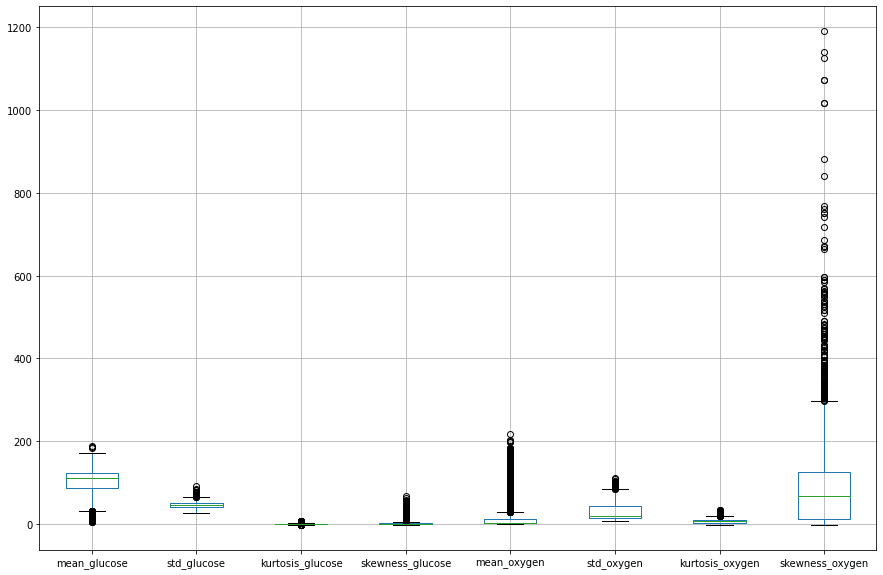

In [78]:
fig, ax = plt.subplots(figsize=(15,10))
columns = pd.DataFrame(data=data_before, columns=['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
columns.boxplot()

<AxesSubplot:>

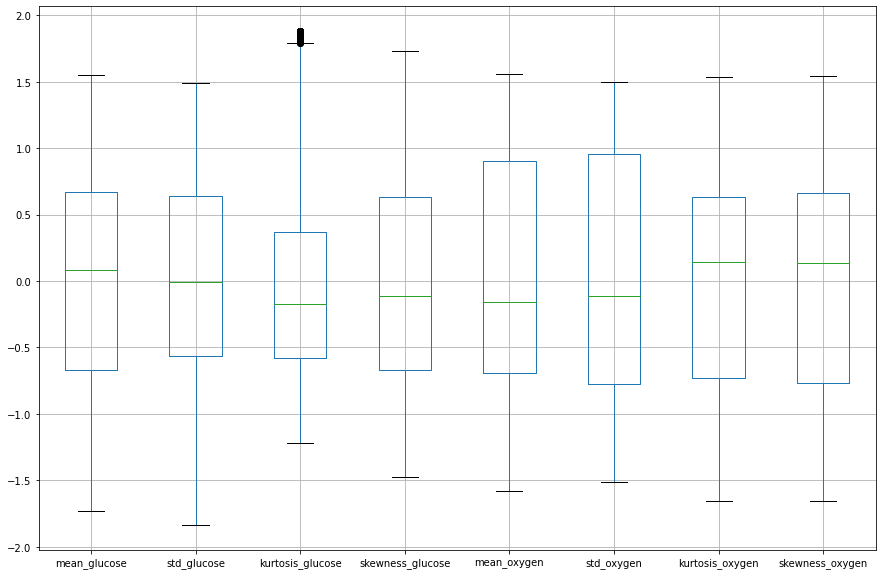

In [79]:
fig, ax = plt.subplots(figsize=(15,10))
columns = pd.DataFrame(data=data, columns=['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
columns.boxplot()

Po vykreslení boxplotov je možné vidieť, zmenu v počtoch vychýlených hodnôt, ale aj jednotlivých distribúciách.

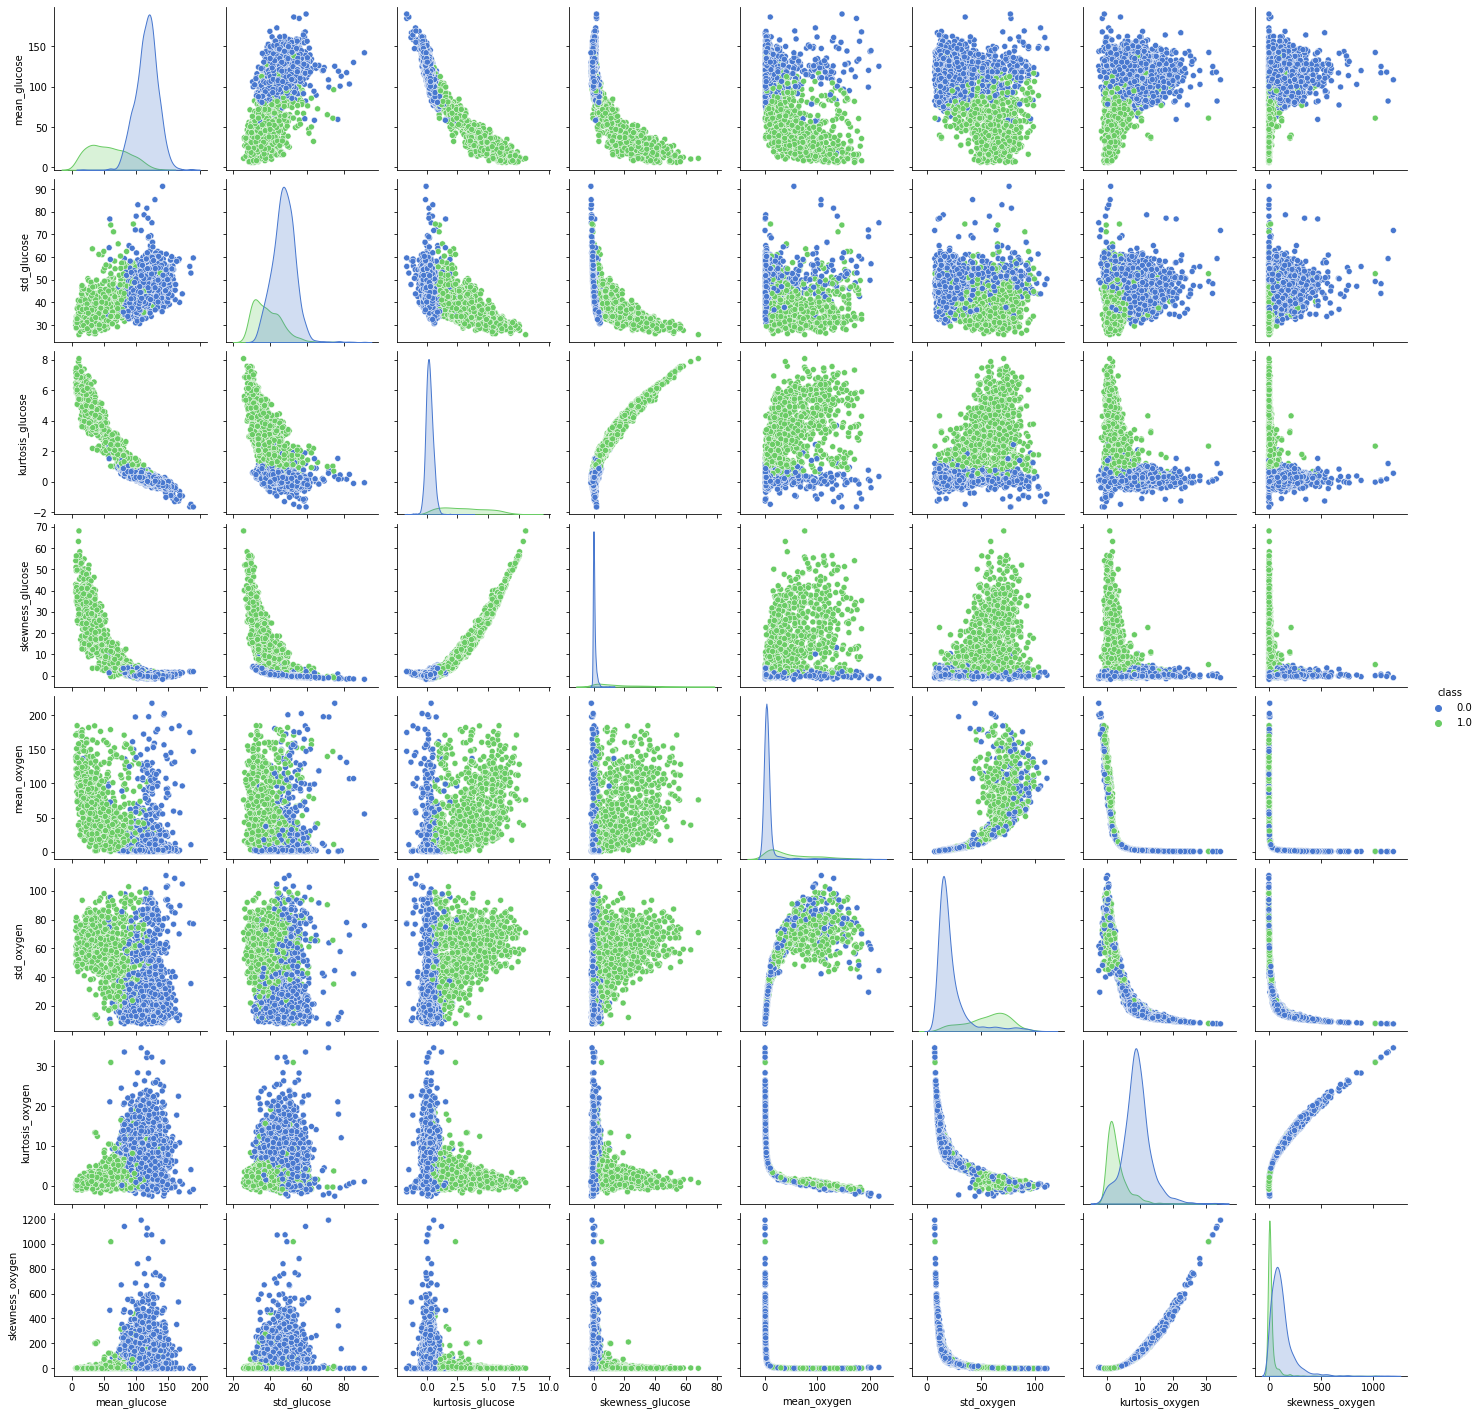

In [80]:
newPalette = {}
newPalette[0.0] = "#4878CF"
newPalette[1.0] = "#6ACC65"
sns.pairplot(data_before, vars=['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'], hue='class', kind='scatter', palette=newPalette)

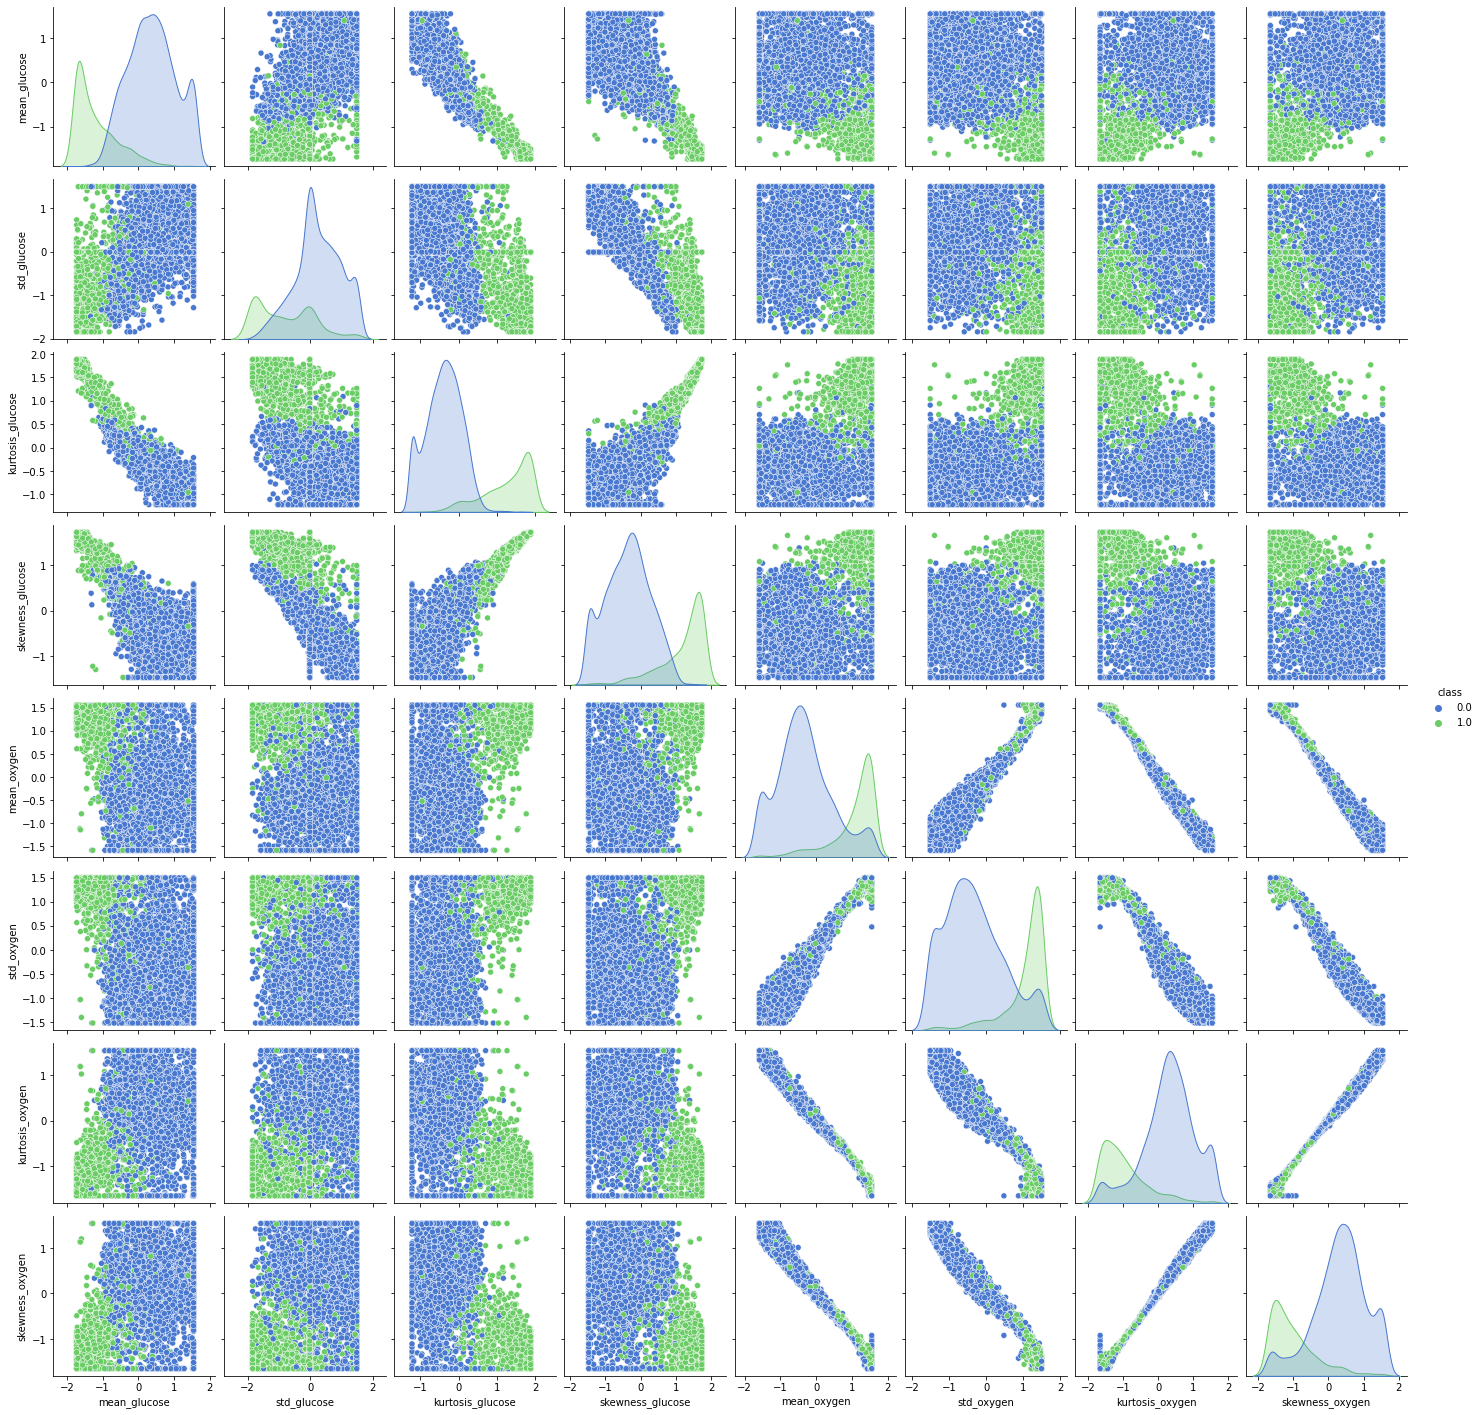

In [81]:
newPalette = {}
newPalette[0.0] = "#4878CF"
newPalette[1.0] = "#6ACC65"
sns.pairplot(data, vars=['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'], hue='class', kind='scatter',palette=newPalette)

Na základe vypočítaných korelácií sme znázornili grafy len medzi jednotlivými atribútmi medicínskych dát s tým, že sú tam zvýraznené hodnoty pre chorých a pre zdravých pacientov. Týmto vidíme ako sa zmenili hodnoty pred a po modifikácii dát. Po transformácii sú dáta hustejšie pri sebe.

## Zmena kategorických atribútov na číselné

Tým, že potrebujeme previesť všetky kategorické záznamy na číslené využijeme to, že každá kategória sa namapuje na danú číselnú hodnotu. Na to sme vytvorili samostatnú pipeline.

In [82]:
columns = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

pip_encode = Pipeline([('encode', LabelEncoderTransformer(columns))])

pip_encode.fit(data)
data = pip_encode.transform(data)

Z prvých piatich riadkov datasetu je zrejmé, že sa kategorické dáta zmenili na číselné.

In [83]:
data.head()

name   age  sex date_of_birth  race  marital-status  occupation  \
0  Roscoe Bohannon  47.0    0    1972-03-14     4               0           7   
1     Ernest Kline  52.0    1    1967-02-10     4               2           9   
2  Harold Hendriks  47.0    0    1972-12-15     4               2          11   
3   Randy Baptiste  43.0    1    1976-03-16     4               2           9   
4  Anthony Colucci  68.0    1    1951-05-04     4               0           9   

   pregnant  education-num  relationship  ...  std_glucose kurtosis_glucose  \
0         0            7.0             4  ...     0.335067        -0.889276   
1         0           15.0             0  ...     0.931622        -0.180434   
2         0            9.0             5  ...     0.448172         0.094380   
3         0            4.0             0  ...    -0.189139        -0.144815   
4         0           13.0             4  ...    -1.780007         1.592827   

   skewness_glucose  mean_oxygen  std_oxygen  kurtosis_oxygen  \
0         -0.081816     0.517613    0.575454        -0.403664   
1         -0.335882    -0.687507   -0.302831         0.541247   
2         -0.216430    -0.440065   -0.851440         0.354717   
3          0.035531    -1.377860   -0.805792         1.261308   
4          1.564671     0.695572    0.784124        -0.503285   

   skewness_oxygen  street  town   psc  
0        -0.442486    2506   554  2848  
1         0.449347    1384   821  1515  
2         0.496453    3043  1735   826  
3         1.140765     995  2993   764  
4        -0.539321    3142  3098   855  

[5 rows x 30 columns]

## Feature selection

<AxesSubplot:>

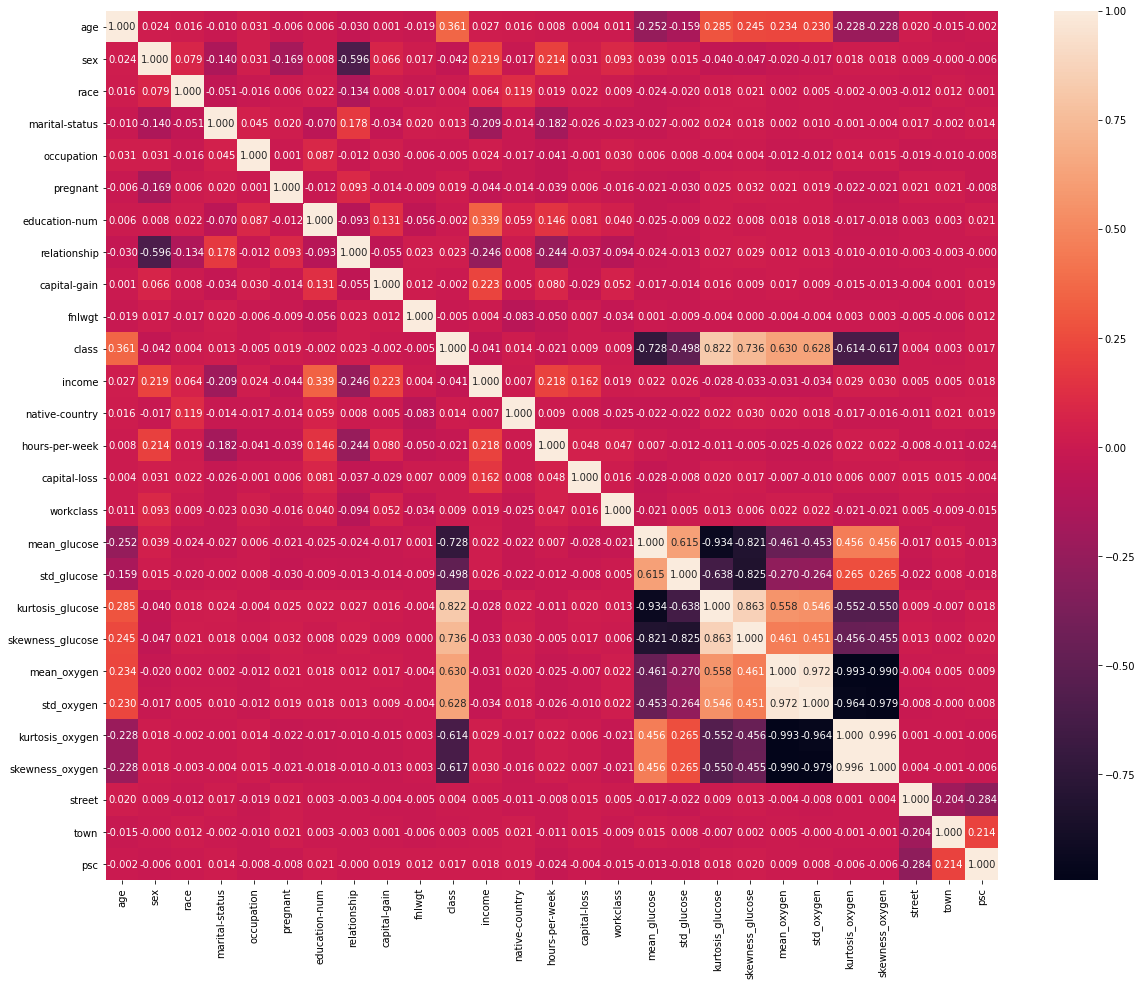

In [84]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".3f")

Dali sme vykresliť mapu korelácií medzi jednotlivými atribútmi už po zmene kategorických na číselné hodnoty. Sledujeme najviac riadok pre atribút class, kde vidíme, s ktorými atribútmi najviac koreluje. Ide najmä o atribút vek a zdravotné záznamy pacienta.

Vytvorili sme kópiu dát bez atribútov class, meno, adresa, dátum narodenia a education, keďže tento atribút je namapovaný v atribúte education-num.

In [85]:
data_copy = data.drop(columns=['class', 'name', 'date_of_birth', 'education'])

In [86]:
data_copy.head()

age  sex  race  marital-status  occupation  pregnant  education-num  \
0  47.0    0     4               0           7         0            7.0   
1  52.0    1     4               2           9         0           15.0   
2  47.0    0     4               2          11         0            9.0   
3  43.0    1     4               2           9         0            4.0   
4  68.0    1     4               0           9         0           13.0   

   relationship  capital-gain    fnlwgt  ...  std_glucose  kurtosis_glucose  \
0             4           0.0  1.479292  ...     0.335067         -0.889276   
1             0           0.0  0.267369  ...     0.931622         -0.180434   
2             5           0.0 -0.797937  ...     0.448172          0.094380   
3             0           0.0  0.157293  ...    -0.189139         -0.144815   
4             4           0.0  0.343722  ...    -1.780007          1.592827   

   skewness_glucose  mean_oxygen  std_oxygen  kurtosis_oxygen  \
0         -0.081816     0.517613    0.575454        -0.403664   
1         -0.335882    -0.687507   -0.302831         0.541247   
2         -0.216430    -0.440065   -0.851440         0.354717   
3          0.035531    -1.377860   -0.805792         1.261308   
4          1.564671     0.695572    0.784124        -0.503285   

   skewness_oxygen  street  town   psc  
0        -0.442486    2506   554  2848  
1         0.449347    1384   821  1515  
2         0.496453    3043  1735   826  
3         1.140765     995  2993   764  
4        -0.539321    3142  3098   855  

[5 rows x 26 columns]

Po výpise vidíme, že dáta obsahujú len číselné atribúty.

Vytvorili sme funkciu na výber K najlepších features pre dáta na základe cieľovej hodnoty, v našom prípade class.

In [87]:
kBest = KBestFeaturesTransformer(k=9)
x = kBest.transform(data_copy, data['class'])

(3932, 9)


Vybrali sme 9 najlepších features pre dáta na základe ktorých sa bude určovať hodnota v atribúte class.

Vypísali sme prvý záznam aj pre dáta x aj pre dáta y.

In [88]:
print(x[0])

[47.          0.75185177  0.33506707 -0.88927624 -0.08181569  0.51761307
  0.57545394 -0.40366447 -0.44248615]


In [89]:
y = data['class']
print(y[0])

0.0


## Dimension reduction

Je potrebné zredukovať dáta z našich 9 hodnôt na menší počet. Pre túto úlohu sme vytvorili funkciu, ktorá zredukuje počet atribútov na 2.

In [91]:
reduceDimension = DimensionReductionTransformer()

x_reduced = reduceDimension.transform(x)

SVD: reduced shape (3932, 2)


bug... https://stackoverflow.com/questions/33447808/sklearns-plsregression-valueerror-array-must-not-contain-infs-or-nans

Po redukcii sme dali vypísať prvý záznam.

In [92]:
print(x_reduced[0])

[46.99922127 -0.06203248]


Vytvorili sme funkciu na vykreslenie redukovaných dát s rozlíšením chorých a zdravých pacientov. Následne sme naše výsledné dáta vykreslili.

In [93]:
def plotReduced(x, y):
    plt.figure()
    colors = ['#4878CF', '#6ACC65']
    lw = 2

    for color, i in zip(colors, [0, 1]):
        plt.scatter(x[y == i, 0], 
                    x[y == i, 1], 
                    color=color, 
                    alpha=.8, 
                    lw=lw,
                    label=i)
    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    return

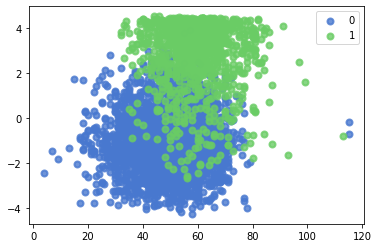

In [94]:
plotReduced(x_reduced, y)

### Záver

V tretej fáze vytvorenú pipeline spustíme opäť na trénovacích dátach, aby sme natrénovali model (využijeme aj fit aj transform). V rámci tohoto modelu sa zapamätajú priemery, najfrekventovanejšie hodnoty a kódovanie kategorických atribútov na číslené z trénovacej sady. A následne tento model spustíme nad testovacou vzorkou (využijeme len transform) a tým zabezpečíme, aby chýbajúce hodnoty boli nahradené priemerom a najfrekventovanejšou hodnotou z trénovacej sady. Zároveň tak zabezpečíme aby jednotlivé kategórie boli mapované na rovnaké číslené hondoty.

Nakoniec sme vytvorili csv súbor, v ktorom sú uložené upravené dáta.

In [98]:
data.to_csv(r'merged_train.csv',index=False)